In [1]:
import torch
from transformers import AutoModelForCausalLM

target_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    torch_dtype = torch.float16,
    device_map = "auto"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
from typing import Optional, Tuple

multiplied = []
cos = torch.nn.CosineSimilarity(dim=0)

def partial_forward(
    model,
    hidden_states: torch.Tensor,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    past_key_value: Optional[Tuple[torch.Tensor]] = None,
    output_attentions: Optional[bool] = False,
    use_cache: Optional[bool] = False,
    **kwargs,
) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:

    residual = hidden_states

    hidden_states = model.input_layernorm(hidden_states)

    # Self Attention
    hidden_states, self_attn_weights, present_key_value = model.self_attn(
        hidden_states=hidden_states,
        attention_mask=attention_mask,
        position_ids=position_ids,
        past_key_value=past_key_value,
        output_attentions=output_attentions,
        use_cache=use_cache,
    )
    
    #hidden_states = residual + hidden_states

    # Fully Connected
    #residual = hidden_states
    #hidden_states = model.post_attention_layernorm(hidden_states)
    #hidden_states = model.mlp(hidden_states)
    
    return residual, hidden_states


def get_vectors(name):
    def hook(model, input):
        residual, hidden_states = partial_forward(model, *input)
        pre = torch.flatten(residual.to("cuda:0"))
        post = torch.flatten(hidden_states.to("cuda:0"))
        similarity = torch.abs(cos(pre, post)).detach().to("cpu").numpy()
        multiplied.append({
            "name": name,
            "similarity": similarity
        })
    return hook

for idx, layer in enumerate(target_model.model.layers):
    layer.register_forward_pre_hook(get_vectors(f"layer_{idx}"))

### Test

In [3]:
from transformers import pipeline, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

pipe = pipeline(
    "text-generation",
    model = target_model,
    tokenizer = tokenizer
)

pipe.tokenizer.pad_token_id = target_model.config.eos_token_id

pipe(
    "What's ML?",
    do_sample = False,
    max_new_tokens = 100,
    return_full_text = False
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '\n\nComment: @JamesK. I\'m not sure what you mean by "ML" - could you clarify?\n\nComment: @JamesK I\'m not sure what you mean by "ML" - could you clarify?\n\nComment: @JamesK I\'m not sure what you mean by "ML" - could you clarify?\n\nComment: @JamesK I\'m not sure what you mean by "ML" -'}]

In [4]:
sorted(multiplied, key = lambda x: x["similarity"], reverse = True)

[{'name': 'layer_31', 'similarity': array(0.956, dtype=float16)},
 {'name': 'layer_5', 'similarity': array(0.4795, dtype=float16)},
 {'name': 'layer_23', 'similarity': array(0.41, dtype=float16)},
 {'name': 'layer_9', 'similarity': array(0.3477, dtype=float16)},
 {'name': 'layer_22', 'similarity': array(0.3418, dtype=float16)},
 {'name': 'layer_31', 'similarity': array(0.338, dtype=float16)},
 {'name': 'layer_4', 'similarity': array(0.3342, dtype=float16)},
 {'name': 'layer_20', 'similarity': array(0.3218, dtype=float16)},
 {'name': 'layer_6', 'similarity': array(0.3167, dtype=float16)},
 {'name': 'layer_31', 'similarity': array(0.3047, dtype=float16)},
 {'name': 'layer_31', 'similarity': array(0.3035, dtype=float16)},
 {'name': 'layer_31', 'similarity': array(0.3013, dtype=float16)},
 {'name': 'layer_31', 'similarity': array(0.2974, dtype=float16)},
 {'name': 'layer_30', 'similarity': array(0.2825, dtype=float16)},
 {'name': 'layer_31', 'similarity': array(0.2803, dtype=float16)},
 {'

### More robust test

In [40]:
from datasets import load_dataset

dataset = load_dataset("HuggingFaceH4/ultrachat_200k", split = "train_sft")
subset = dataset.select(range(100)).shuffle()

In [43]:
from transformers.pipelines.pt_utils import KeyDataset
from tqdm import tqdm

multiplied = []


result = pipe(
    subset["prompt"],
    do_sample = False,
    max_new_tokens = 2048,
    return_full_text = False
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

KeyboardInterrupt: 

In [44]:
import pandas as pd
import numpy as np

sim_pd = []

for item in multiplied:

    sim_pd.append({
        "layer": item["name"],
        "similarity": float(item["similarity"])
    })

df = pd.DataFrame.from_dict(sim_pd, orient = "columns")

In [45]:
df.groupby("layer").median().reset_index().sort_values("similarity", ascending = False)

,layer,similarity
22,layer_29,0.159546
11,layer_19,0.137939
8,layer_16,0.084167
7,layer_15,0.083313
27,layer_5,0.082794
21,layer_28,0.081604
26,layer_4,0.080139
14,layer_21,0.079468
24,layer_30,0.069946
17,layer_24,0.067322


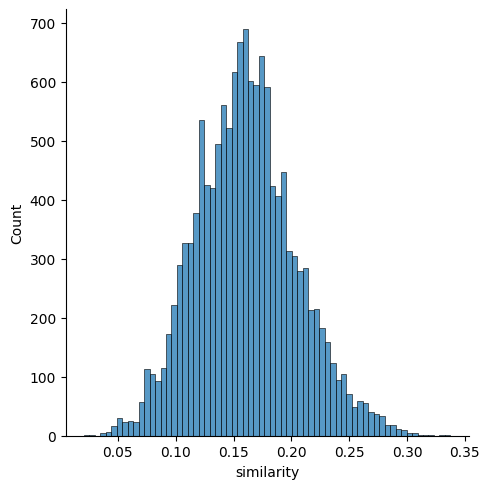

In [46]:
import seaborn as sns

sns.displot(df[df.layer == "layer_29"].similarity)

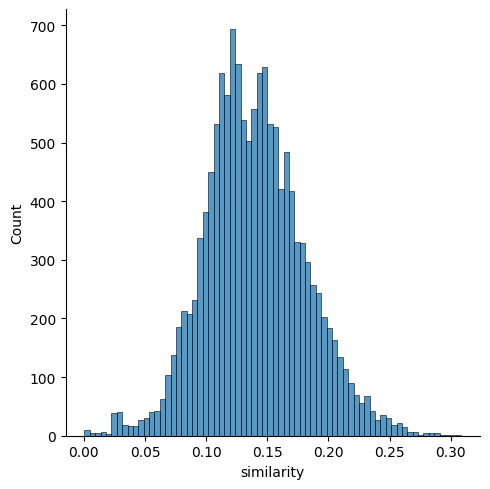

In [47]:
import seaborn as sns

sns.displot(df[df.layer == "layer_19"].similarity)

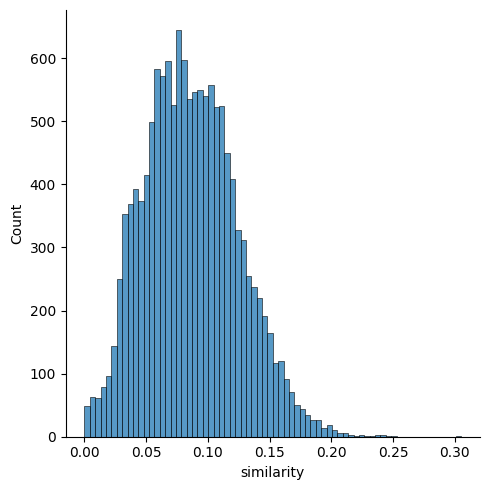

In [48]:
import seaborn as sns

sns.displot(df[df.layer == "layer_16"].similarity)